<table class="table table-bordered">
    <tr>
        <th style="width:250px"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 100%; height: 125px; "></th>
        <th style="text-align:center;"><h1>Data Wrangling</h1><h2>Assignment 1 </h2><h3>Diploma in Data Science</h3></th>
    </tr>
</table>

In [1]:
# Importing the packages
import pandas as pd
import numpy as np
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
# Feature Engine
import feature_engine.imputation as mdi
from feature_engine.imputation import EndTailImputer
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.encoding import OneHotEncoder
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.outliers import Winsorizer
# Visuals
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Load Data into Jupyter Notebook

In [2]:
df = pd.read_csv('./supermarket.csv')
#Initial inspection of the data
print(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB
None


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


### Step 2: Data Preprocessing

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


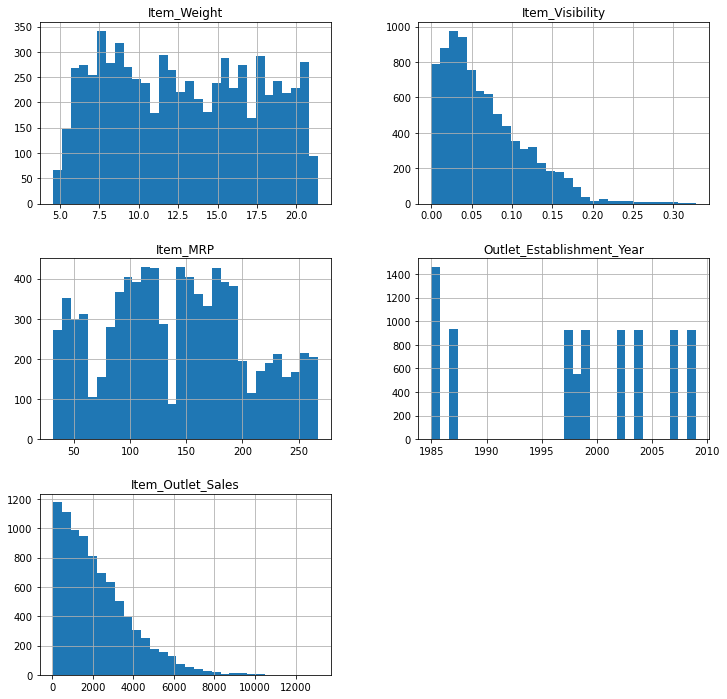

In [3]:
#Declaring the numerical and categorical variables
num_cols = [c for c in df.columns if df[c].dtypes !='O']
cat_cols = [c for c in df.columns if df[c].dtypes == 'O']

#Preliminary look at the range of data for each numerical column
display(df[num_cols].describe())
#Examining the distribution of the numerical variables
df[num_cols].hist(bins=30, figsize=(12,12))
plt.show()

In [4]:
#Printing the unique values for each column
def print_unique(data):
    for cc in cat_cols:
        uv = data[cc].unique()
        print(cc+": ")
        print(uv)

def diagnostic_plots(df, variable):
    plt.figure(figsize=(16, 4))
    plt.subplot(1, 3, 1)
    sns.distplot(df[variable], bins=50)
    plt.title('Histogram')
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.ylabel('RM quantiles')
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')
    plt.show()

#Examining the data in the categorical variables
print_unique(df)
#Checking the data for null values
df.isnull().sum()

Item_Identifier: 
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content: 
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
Item_Type: 
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier: 
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size: 
['Medium' nan 'High' 'Small']
Outlet_Location_Type: 
['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type: 
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [5]:
#Changing the Item_Fat_Content variable
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['low fat', 'LF'],'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(['reg'],'Regular')
print_unique(df)

Item_Identifier: 
['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
Item_Fat_Content: 
['Low Fat' 'Regular']
Item_Type: 
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
Outlet_Identifier: 
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
Outlet_Size: 
['Medium' nan 'High' 'Small']
Outlet_Location_Type: 
['Tier 1' 'Tier 3' 'Tier 2']
Outlet_Type: 
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


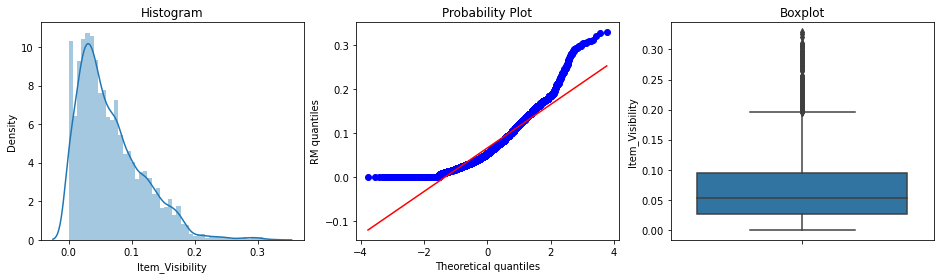

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


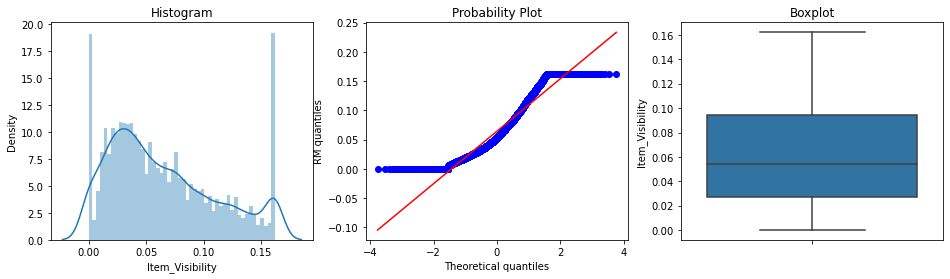

In [6]:
#Pre-transformation
diagnostic_plots(df, 'Item_Visibility')
#Removing outliers for Item Visibility 
windsorizer = Winsorizer(capping_method='iqr', # IQR as the distribution is skewed
                          tail='right', # Cap right as the outliers are at the top
                          fold=1,
                          variables=['Item_Visibility'])

windsorizer.fit(df)
df_tf = windsorizer.transform(df)
#Post-transformation
diagnostic_plots(df_tf, 'Item_Visibility')

### Step 3: Train and Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
df_tf.drop('Item_Outlet_Sales', axis = 1), df_tf['Item_Outlet_Sales'],test_size = 0.3, random_state=0)
#Splitting and checking the shape of the training and test sets
X_train.shape, X_test.shape

((5966, 11), (2557, 11))

### Step 4: Missing Value Imputation

Item_Identifier                 0
Item_Weight                  1021
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1681
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


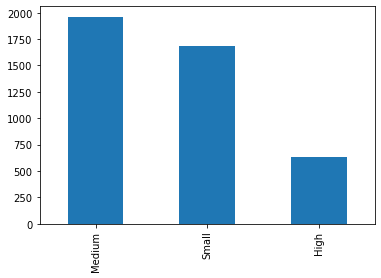

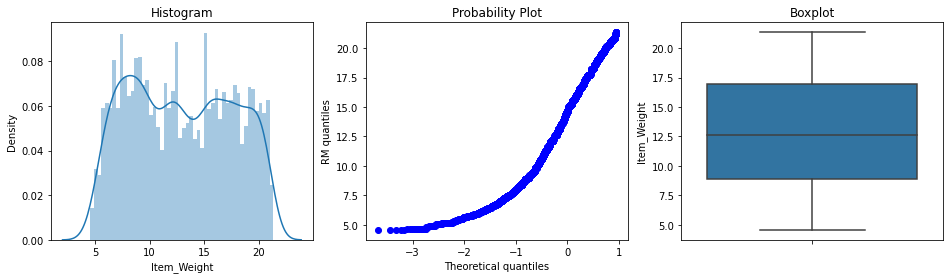

In [8]:
#Checking the data for null values
print(X_train.isnull().sum())
#Checking the frequency of unique values in Outlet_Size
print(X_train['Outlet_Size'].value_counts().plot.bar())
diagnostic_plots(X_train, 'Item_Weight')

In [9]:
#Replacing the missing values 

imputer = EndTailImputer(imputation_method='iqr', tail='right', fold =1.5, 
                         variables=['Item_Weight'])
imputer.fit(X_train)
X_train_mvi = imputer.transform(X_train)
X_test_mvi = imputer.transform(X_test)
features_cat_frequent = ['Outlet_Size']
pipe = Pipeline(
    steps = [('imp_cat_frequent', mdi.CategoricalImputer(variables = features_cat_frequent, imputation_method = 'frequent'))
])
pipe.fit(X_train_mvi)
X_train_mvi = pipe.transform(X_train_mvi)
X_test_mvi = pipe.transform(X_test_mvi)

AxesSubplot(0.125,0.125;0.775x0.755)


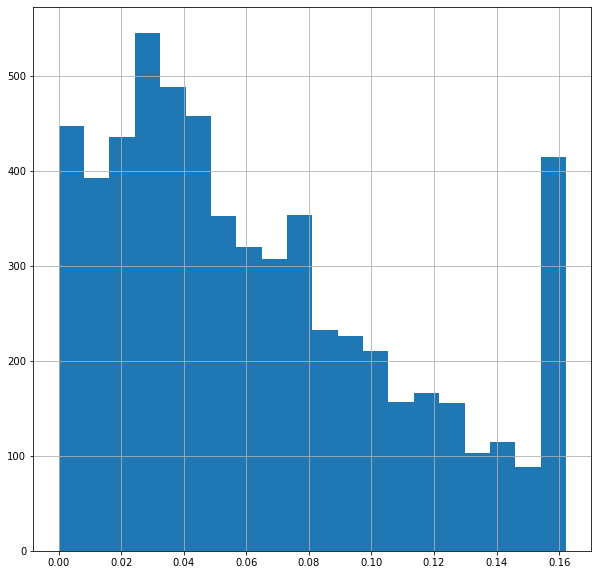

In [10]:
#Transforms Item_Visibility to be more normally distributed
print(X_train_mvi['Item_Visibility'].hist(bins=20, figsize = (10,10)))
yjt = YeoJohnsonTransformer(variables = ['Item_Visibility'])
yjt.fit(X_train_mvi)
X_train_pt = yjt.transform(X_train_mvi)
X_test_pt = yjt.transform(X_test_mvi)

AxesSubplot(0.125,0.125;0.775x0.755)


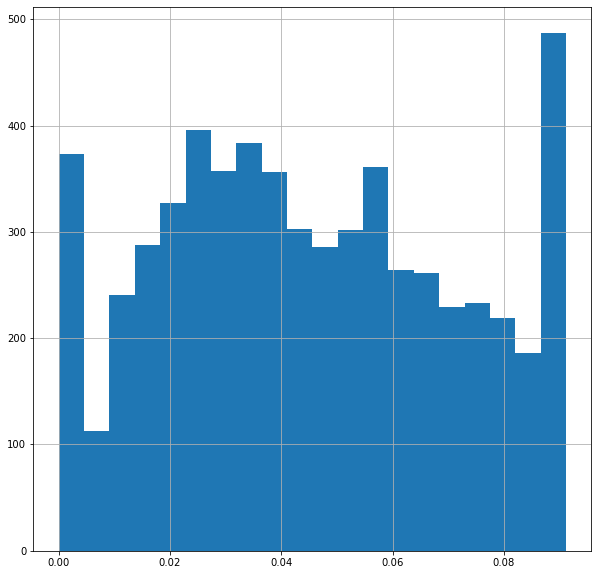

In [11]:
#After transformation
print(X_train_pt['Item_Visibility'].hist(bins=20, figsize = (10,10)))


Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


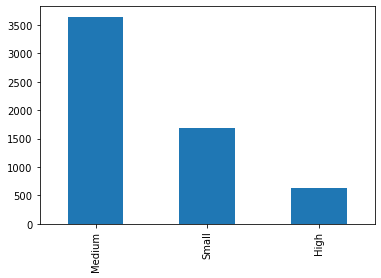

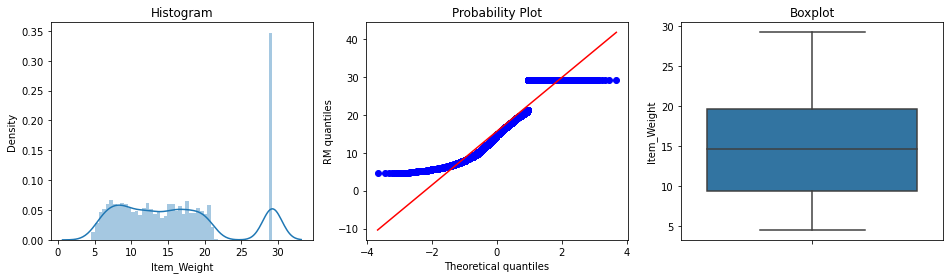

In [12]:
print(X_train_pt.isnull().sum())
print(X_train_pt['Outlet_Size'].value_counts().plot.bar())
diagnostic_plots(X_train_pt, 'Item_Weight')

### Step 5: Categorical Data Encoding

In [13]:
ohe_enc = OneHotEncoder(
    # to indicate how many top categories
    top_categories=10,  
    # we can select which variables to encode
    variables=['Item_Fat_Content','Item_Type','Item_Identifier','Outlet_Identifier','Outlet_Type','Outlet_Size','Outlet_Location_Type'],
    drop_last=False)
ohe_enc.fit(X_train_pt)
X_train_ord = ohe_enc.transform(X_train_pt)
X_test_ord = ohe_enc.transform(X_test_pt)
display(X_train_ord.head())

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Fruits and Vegetables,Item_Type_Snack Foods,Item_Type_Household,Item_Type_Frozen Foods,...,Outlet_Type_Supermarket Type1,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 1
88,6.305,0.078233,95.6436,1997,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
6813,5.980,0.036803,146.8418,2007,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4046,29.225,0.054675,160.7920,1985,1,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
8194,29.225,0.091170,157.8630,1985,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
8293,9.100,0.058994,47.2718,2004,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0


### Step 6: Variable Discretization /Binning

array([[<AxesSubplot:title={'center':'Item_Weight'}>,
        <AxesSubplot:title={'center':'Item_Visibility'}>],
       [<AxesSubplot:title={'center':'Outlet_Establishment_Year'}>,
        <AxesSubplot:title={'center':'Item_MRP'}>]], dtype=object)

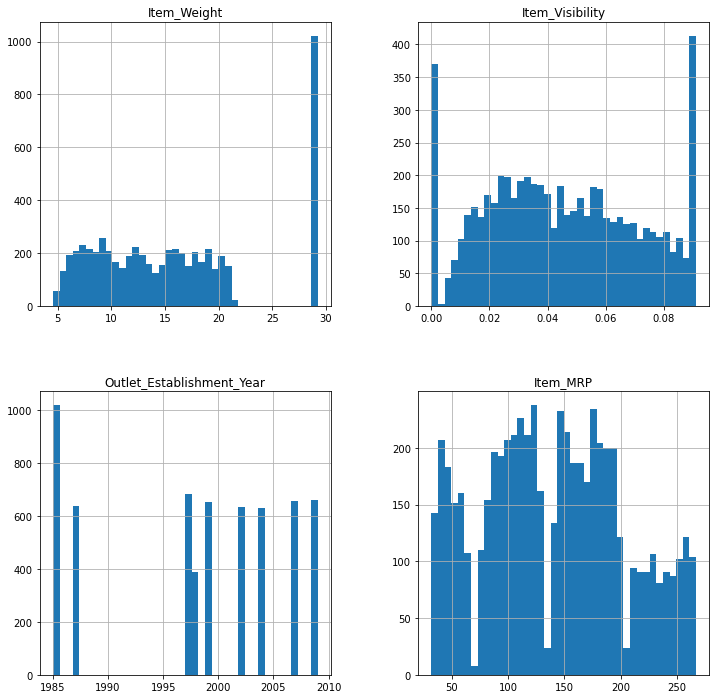

In [14]:
numcol = ['Item_Weight', 'Item_Visibility', 'Outlet_Establishment_Year','Item_MRP']
X_train_ord[numcol].hist(bins=40, figsize=(12,12))

array([[<AxesSubplot:title={'center':'Item_Weight'}>,
        <AxesSubplot:title={'center':'Item_Visibility'}>],
       [<AxesSubplot:title={'center':'Outlet_Establishment_Year'}>,
        <AxesSubplot:title={'center':'Item_MRP'}>]], dtype=object)

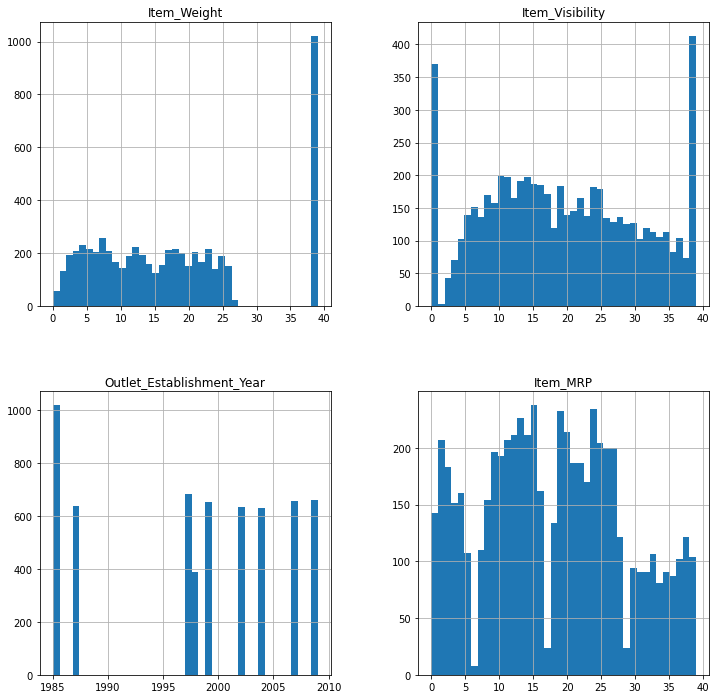

In [15]:
disc = EqualWidthDiscretiser(bins=40, variables = ['Item_Weight', 'Item_Visibility', 'Item_MRP'])
disc.fit(X_train_ord)
train_t = disc.transform(X_train_ord)
test_t = disc.transform(X_test_ord)
train_t[numcol].hist(bins=40, figsize=(12,12))

### Step 7: Feature Engineer

In [16]:
scaler = MinMaxScaler()
# fit the scaler to the train set, it will learn the parameters
scaler.fit(train_t)
# transform train and test sets
X_train_scaled = scaler.transform(train_t)
X_test_scaled = scaler.transform(test_t)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_ord.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_ord.columns)
display(train_t.head())
display(X_train_scaled.head())

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Fruits and Vegetables,Item_Type_Snack Foods,Item_Type_Household,Item_Type_Frozen Foods,...,Outlet_Type_Supermarket Type1,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 1
88,2,34,10,1997,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
6813,2,16,19,2007,1,0,1,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4046,39,23,21,1985,1,0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
8194,39,39,21,1985,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
8293,7,25,2,2004,1,0,0,0,1,0,...,1,0,0,0,0,1,0,0,1,0


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Fruits and Vegetables,Item_Type_Snack Foods,Item_Type_Household,Item_Type_Frozen Foods,...,Outlet_Type_Supermarket Type1,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_Tier 3,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 1
0,0.051282,0.871795,0.256410,0.500000,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.051282,0.410256,0.487179,0.916667,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.000000,0.589744,0.538462,0.000000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1.000000,1.000000,0.538462,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.179487,0.641026,0.051282,0.791667,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [17]:
print(X_train_scaled.shape)
X_train_scaled.drop(['Outlet_Establishment_Year'], axis = 1, inplace = True)
X_test_scaled.drop(['Outlet_Establishment_Year'], axis = 1, inplace = True)
print(X_train_scaled.shape)

(5966, 46)
(5966, 45)


In [18]:
print(X_train_scaled.columns)

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Snack Foods',
       'Item_Type_Household', 'Item_Type_Frozen Foods', 'Item_Type_Dairy',
       'Item_Type_Canned', 'Item_Type_Baking Goods',
       'Item_Type_Health and Hygiene', 'Item_Type_Meat',
       'Item_Type_Soft Drinks', 'Item_Identifier_NCY18',
       'Item_Identifier_FDG09', 'Item_Identifier_FDU13',
       'Item_Identifier_FDF52', 'Item_Identifier_FDO19',
       'Item_Identifier_FDA13', 'Item_Identifier_FDB17',
       'Item_Identifier_FDV38', 'Item_Identifier_FDF21',
       'Item_Identifier_NCX29', 'Outlet_Identifier_OUT046',
       'Outlet_Identifier_OUT018', 'Outlet_Identifier_OUT017',
       'Outlet_Identifier_OUT049', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT013', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT010',
       'Outlet_Identifier_OUT019', 

### Step 8: Linear Regression Modelling

Linear regression is defined as a machine learning model in which the model finds the best fit linear line between the independent and dependent variables in which the aim is to find the best fit linear line and the optimal values of intercept and coefficients such that errors are minimized. For the purpose of this analysis, the goal is to use the X variables e.g. columns other than item outlet sales,to predict the item outlet sales (y variable, or target variable).
### Building and Evaluating the Model
In order to evaluate the model performance of a linear regression model, a range of measures can be used, but in this ASG1 we will focus on only 2:

- Root Mean Square Error (RMSE): The RMSE is the square root of the variance of the residuals, that is, the squared differences between prediction and actual observation. Lower values of RMSE indicate better fit and model performance.
- R-Square: R-square represents the percentage of the response variable variation that is explained by a linear model. The closer to 1.0 the value of R-square, the more indicative of a better fit and model performance.

In [19]:
X_train_final = X_train_scaled
X_test_final = X_test_scaled

y_train_final = y_train
y_test_final = y_test

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [21]:
# Build Linear Regression Model
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train_final, y_train_final)

# Evaluate the Linear Regression Model using Mean Square Error (MSE)
# The lower MSE, the better the model performance
print('train_mse:', mean_squared_error(y_train_final, model_linear_regression.predict(X_train_final)), 
      '\n test_mse:', mean_squared_error(y_test_final, model_linear_regression.predict(X_test_final)))

# Evaluate the Linear Regression Model using R-Square
# The closer the r-square value to 1, the better the model performance
print('train_r-sq:', r2_score(y_train_final, model_linear_regression.predict(X_train_final)), 
      '\n test_r-sq:', r2_score(y_test_final, model_linear_regression.predict(X_test_final)))

train_mse: 1245734.088226638 
 test_mse: 1330326.3205371478
train_r-sq: 0.5635188978980409 
 test_r-sq: 0.5631230262925315


## Report

### Table of Contents
* [Introduction](#intro)
* [Data Exploration](#de)
    * [Jupyter Notebook](#jn)
    * [TIBCO Spotfire](#ts)
* [Data Cleansing](#dc)
    * [Missing Data](#md)
    * [Outliers](#out)
* [Data Transformation](#dt)
    * [Categorical Data](#cd)
    * [Numerical Data](#nd)
* [Feature Engineer](#fe)
    * [Feature Scaling](#fs)
    * [New/Drop Features](#ndf)
* [Linear Regression Model](#lrm)
    * [Build/Evaluate Model](#eval)
* [Summary](#sum)
    * [Summarized findings](#sf)
    * [Improvements](#imp)

### Introduction: Problem Understanding  <a id="intro">
    
In this assigment, we are provided with a Supermarket Dataset. The dataset, which contains data about an item and the outlet the item is in, is to be used to predict the sales of each product at a particular outlet. This allows the management team to adjust the properties of products and outlets to increase the sales of the product.
    
The properties of the product that we are provided with are the weight, its fat content, its category, retail price and its visibility in the store. The properties of the outlet provided are its year of establishment, outlet size, type of location(city), type of store (grocery/supermarket). We are also provided a unique identifier for each item and outlet. Last but not least, we are also provided with the Item's Outlet Sales, which is the amount of sales a particular item has done in a particular store.

We aim to use the data of the items and outlets given to us to predict its outlet sales with a linear regression model. Prior to that, we have to go through the data and prepare it for the model to ensure that it is as accurate as possible. This preparation would include familiarizing ourselves with the data, cleaning it and transforming it.

### Explore the Data <a id="de">
    
In this dataset, we are provided with the properties of the item and the store. The properties of the item that we are provided with are the weight, its fat content, its category, retail price and its visibility in the store. The properties of the outlet provided are its year of establishment, outlet size, type of location(city) and type of store (grocery/supermarket). We are also provided a unique identifier for each item and outlet. Last but not least, we are also provided with the Item's Outlet Sales, which is the amount of sales a particular item has done in a particular store. Item's Outlet Sales are our target variable.
    
##### Jupyter Notebook <a id = "jn">
    
For the numerical values, I made histograms for them to inspect their distribution. From the histograms, I could see that Item Visibility and Item Outlet Sales were right-skewed. Item Visibility also had outliers which could be seen through the boxplot graph included under the `diagnostic_plots` function. Outlet Establishment Year did not have a normal distribution and Item MRP, along with Item Weight had multimodal distributions. I also made use of the `.describe()` function on the numerical variables to see the number of values per variable, along with other info such as the minimum, average and maximum value. 
 
For the categorical variables, I made a `print_unique(data)` function that would display the unique values of each column of the dataset passed into the function. This was useful as it allowed me to see the data for each column. From this, I could see that Item_Fat_Content had values with the same meaning but different capitalisation, causing them to be treated as separate values. I could also see that Outlet_Size was the only column with nan values.

##### TIBCO Spotfire <a id = "ts">    
    
Making use of TIBCO Spotifire, I plotted different variables against our target, Item Outlet Sales, to see if there was any correlation. Inspecting each variable against Item Outlet Sales, I saw that there did not seem to be much correlation and there weren't any obvious linear relationship. 

###### Categorical Data
    
For the categorical data, I used bar charts to plot the average item outlet sales for each unique value. Outlet Location Type, Outlet Type, Fat Content were more surface-level categorical data, and could be seen as ordinal instead of nominal. For Outlet Location Type, the Tier 3 location had the highest average sales, followed by Tier 1 and Tier 2 respectively. For Fat Content, items with low fat content also sold more than those with regular fat content. For the nominal categorical data such as Item Type, the item type with the highest average sales were Starchy Foods. I did not plot for the identifier variables as there were too many and it would not produce a useful graph.

<div>
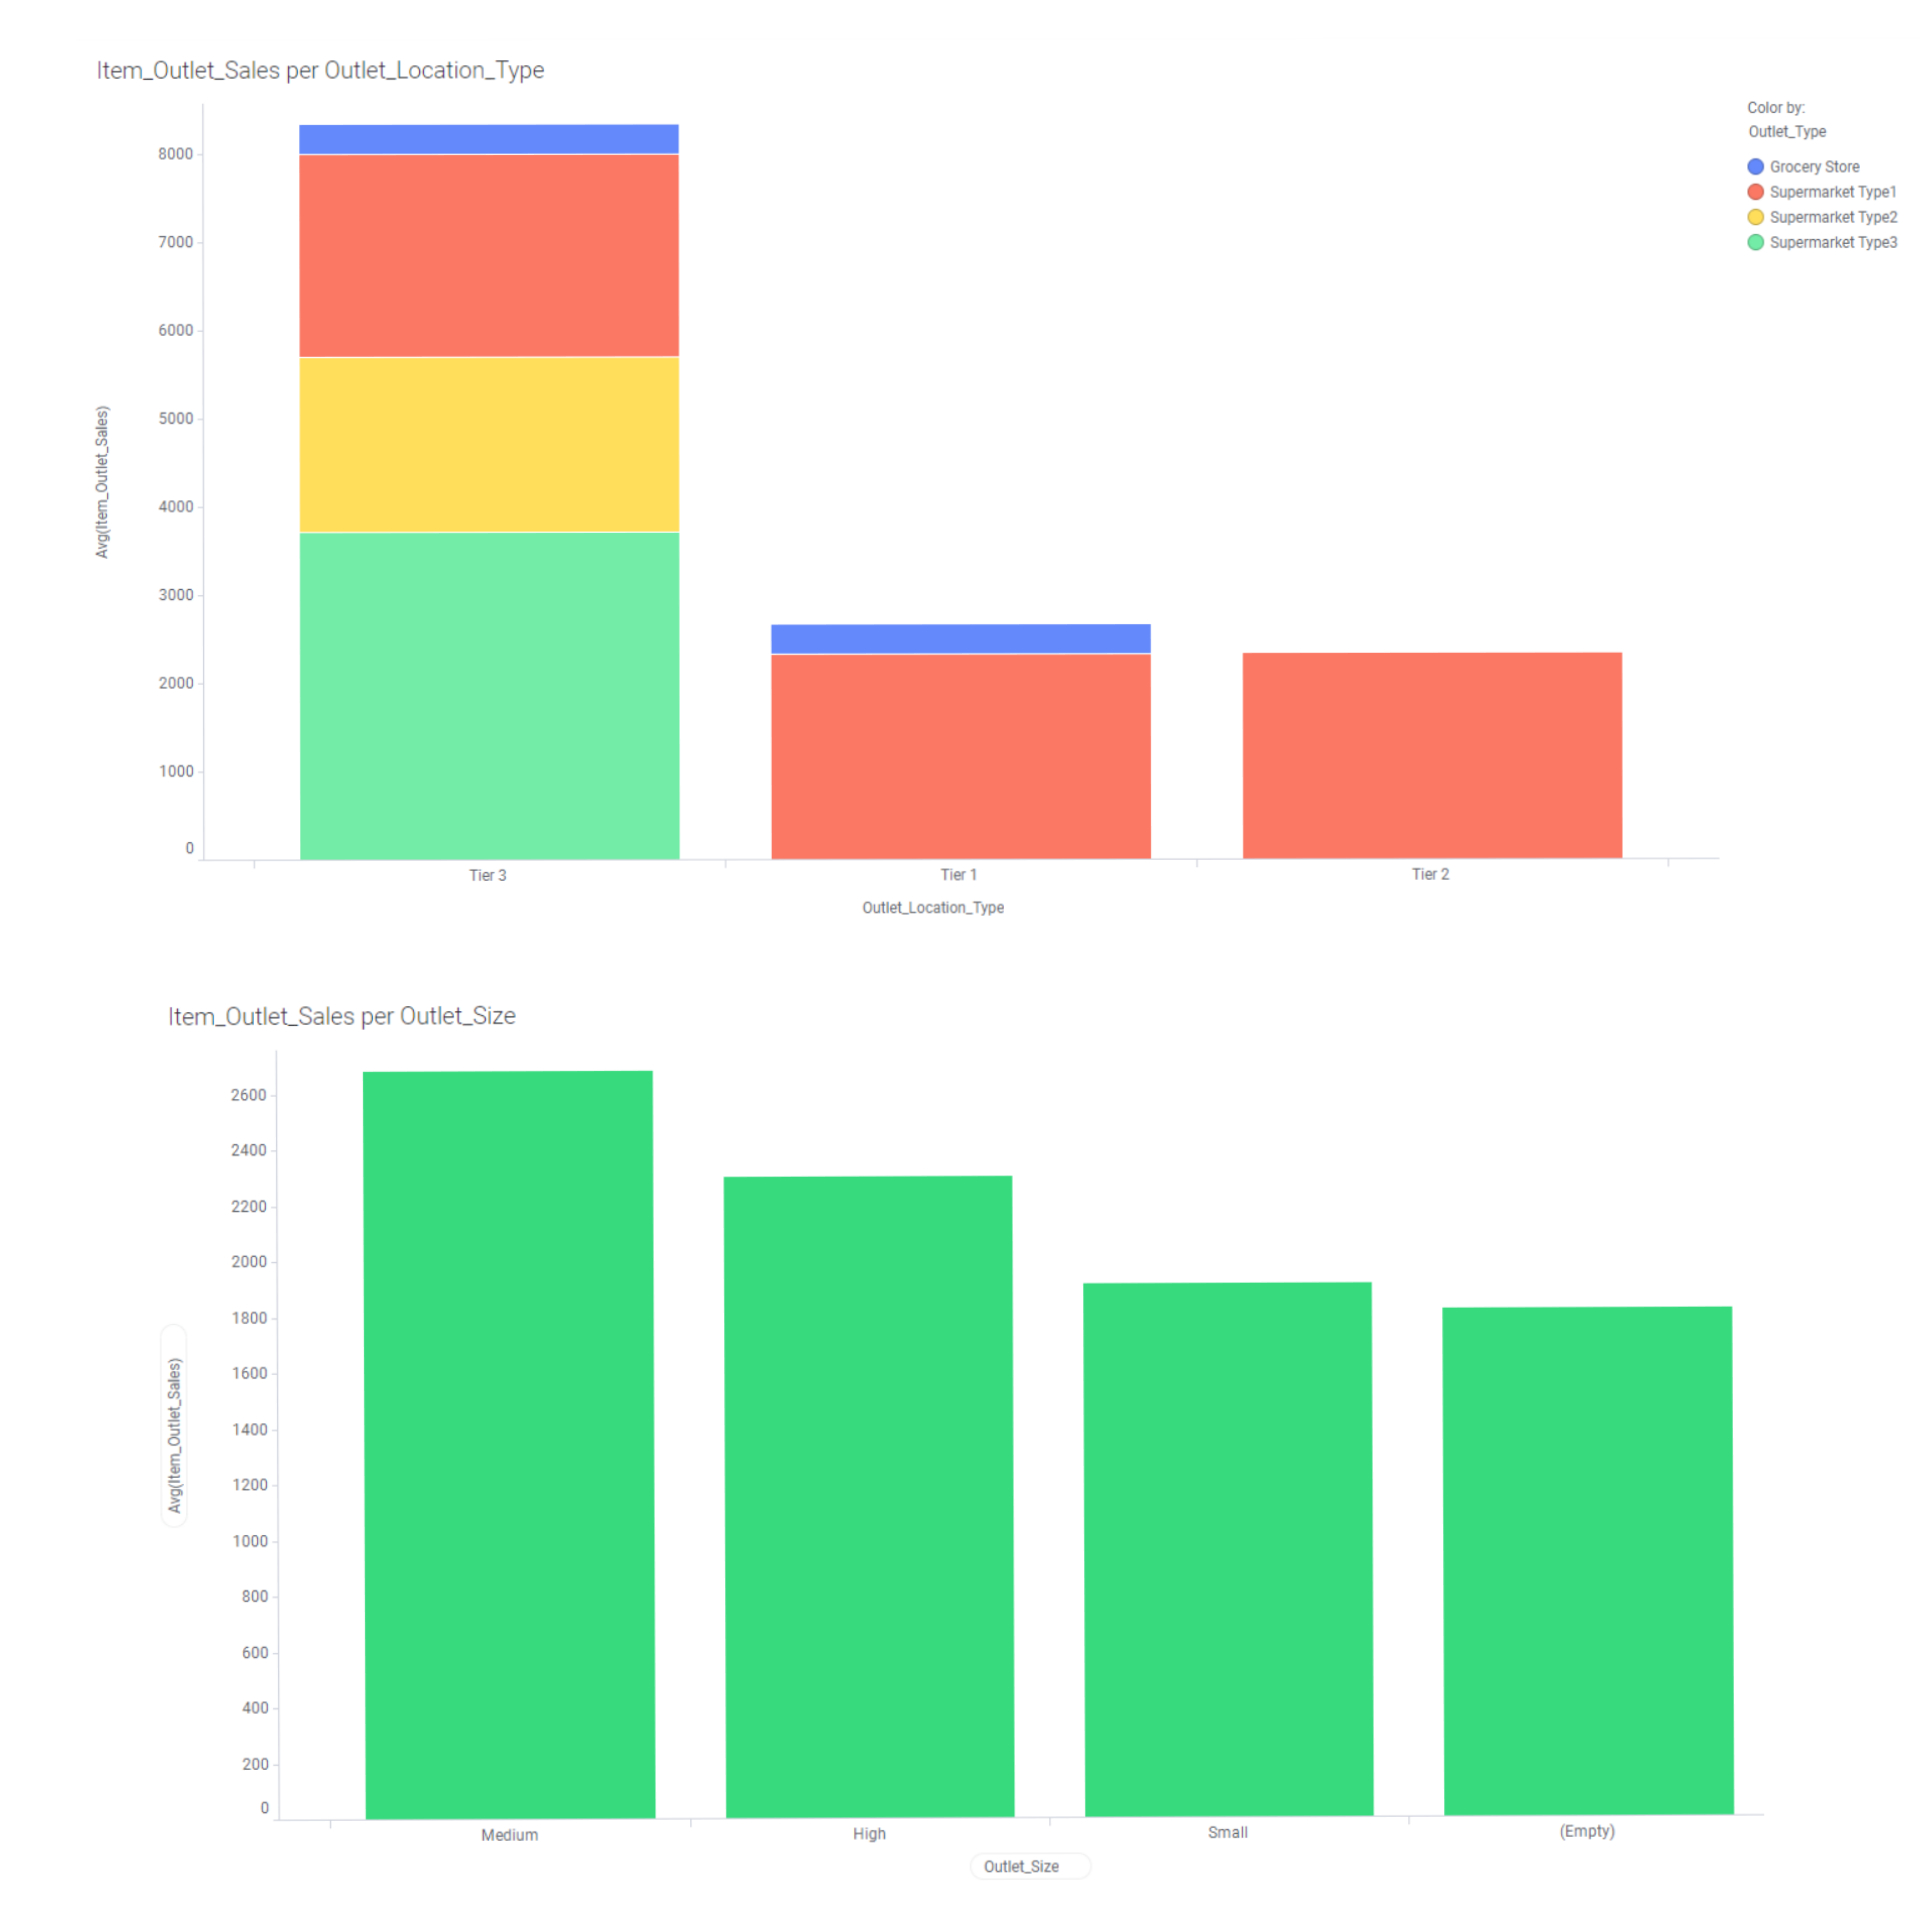
</div>

<div>
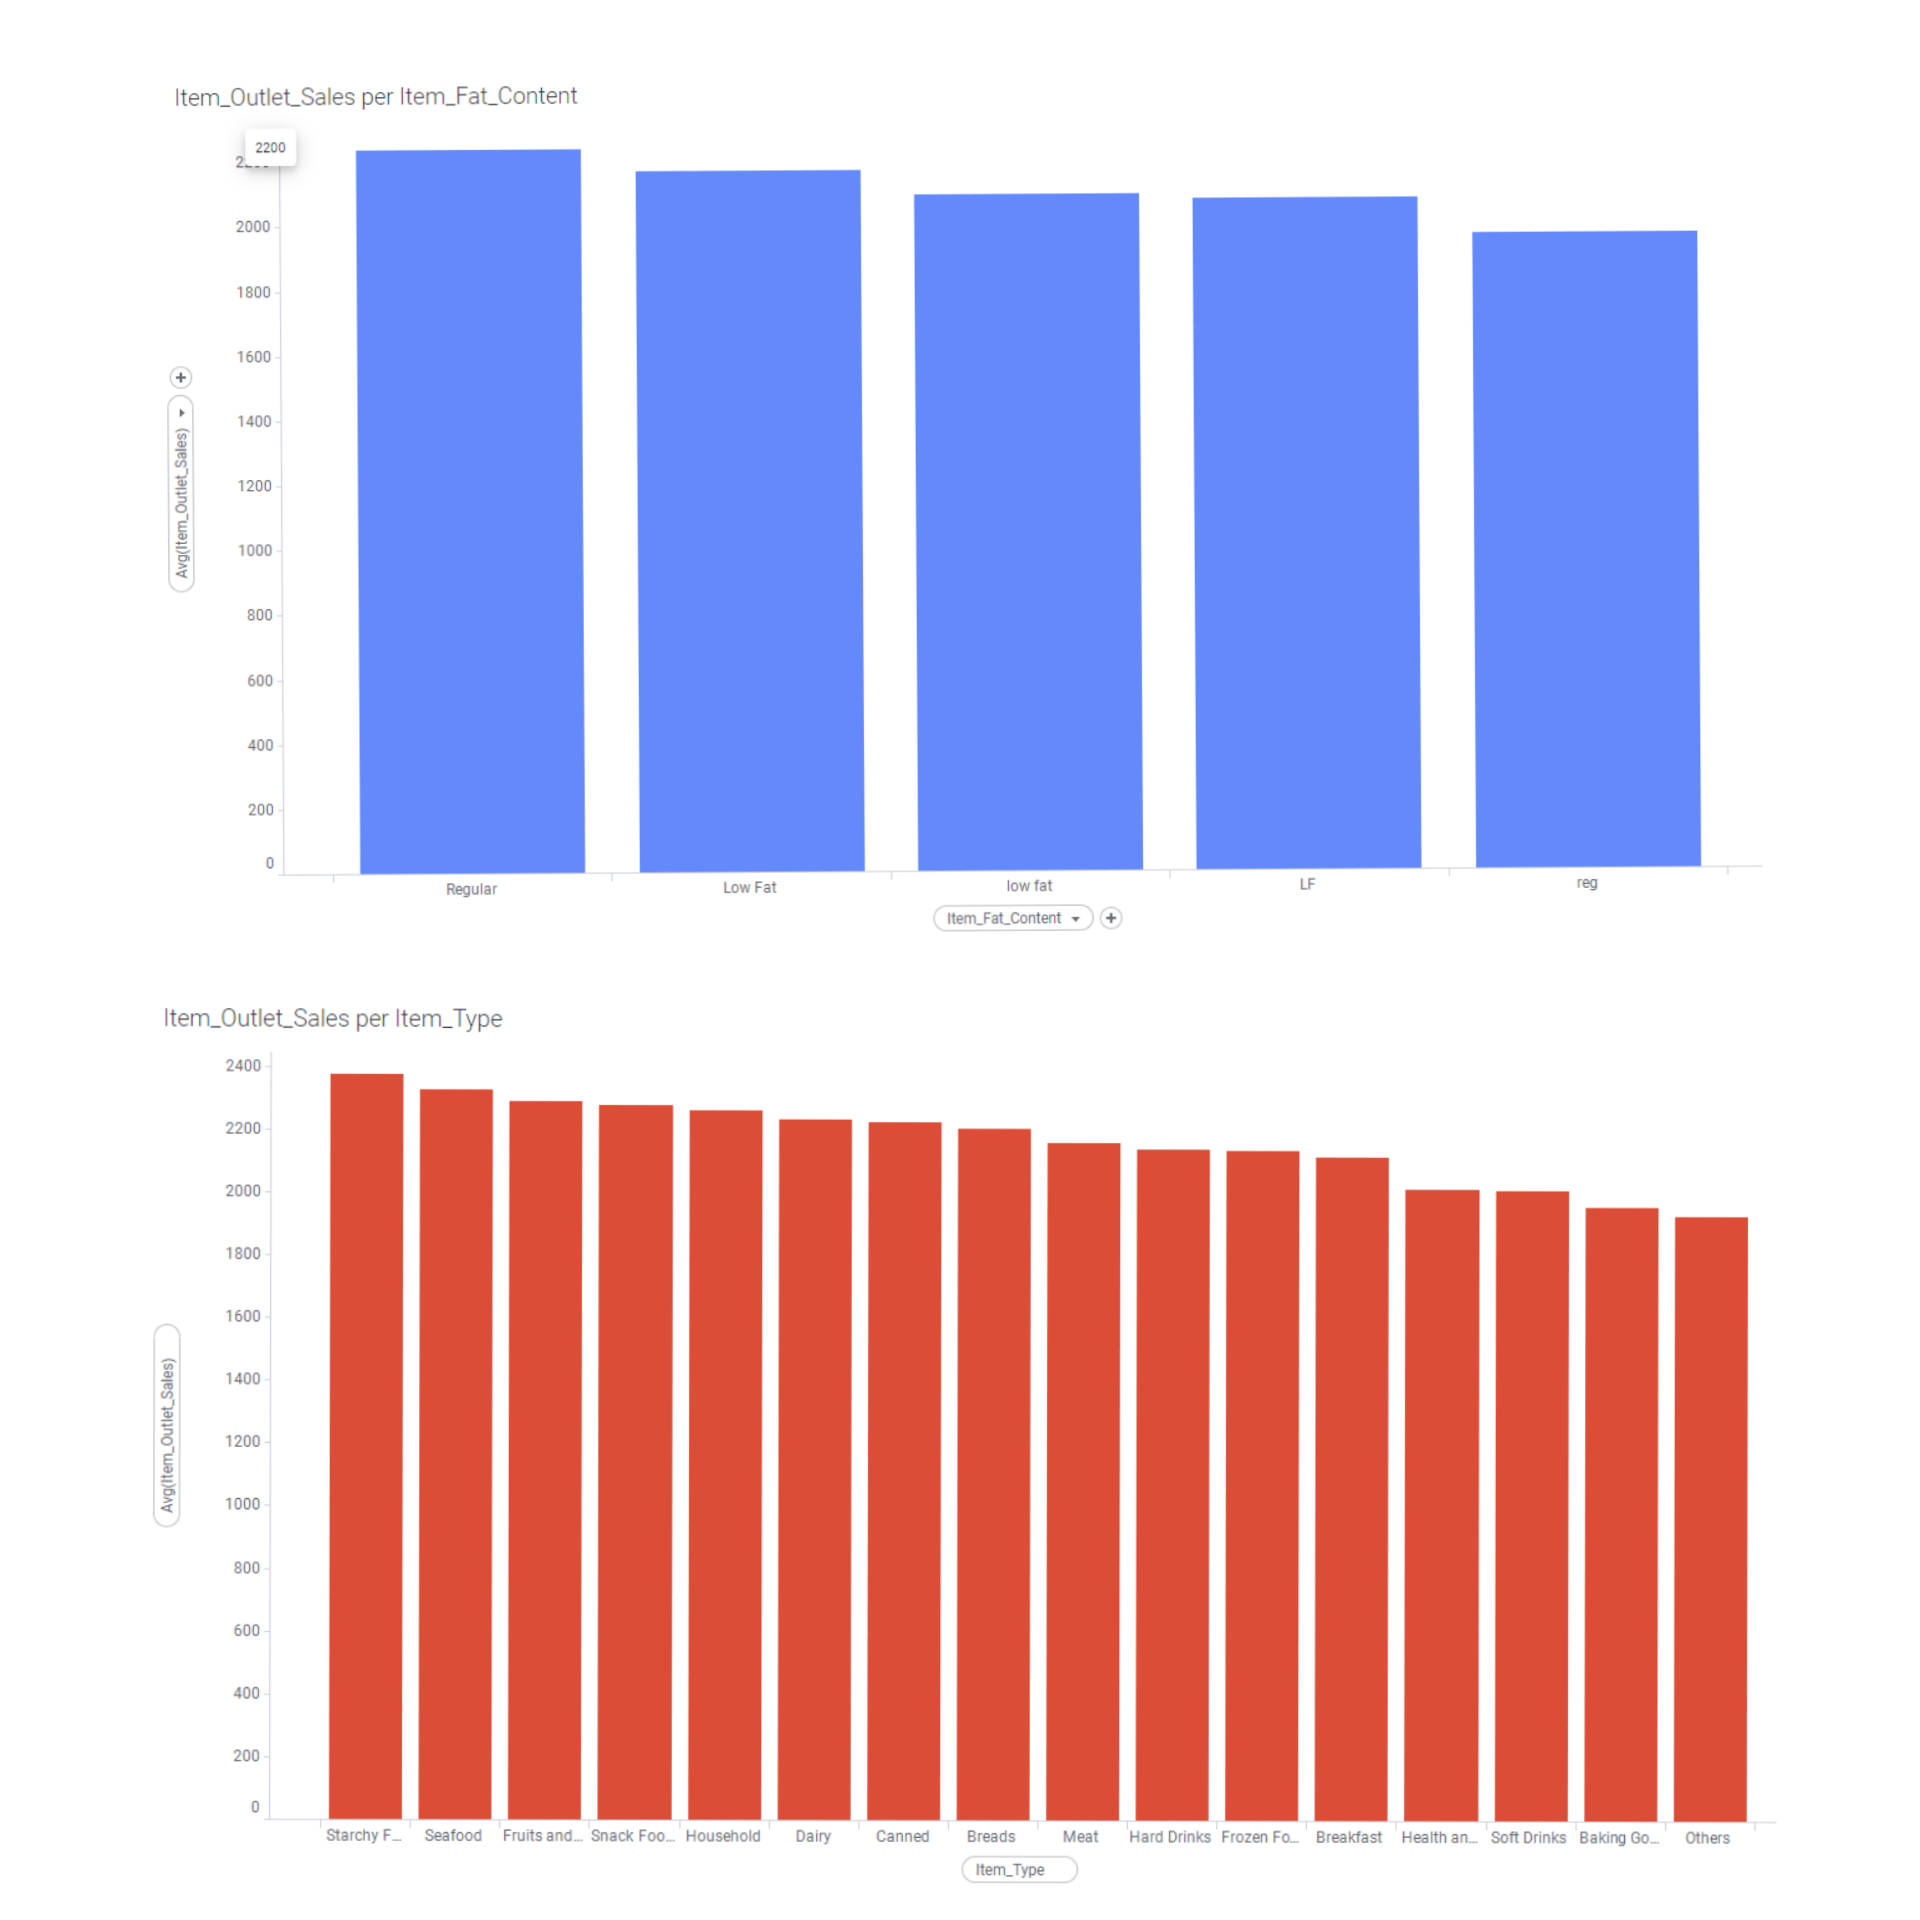
</div>

<div>
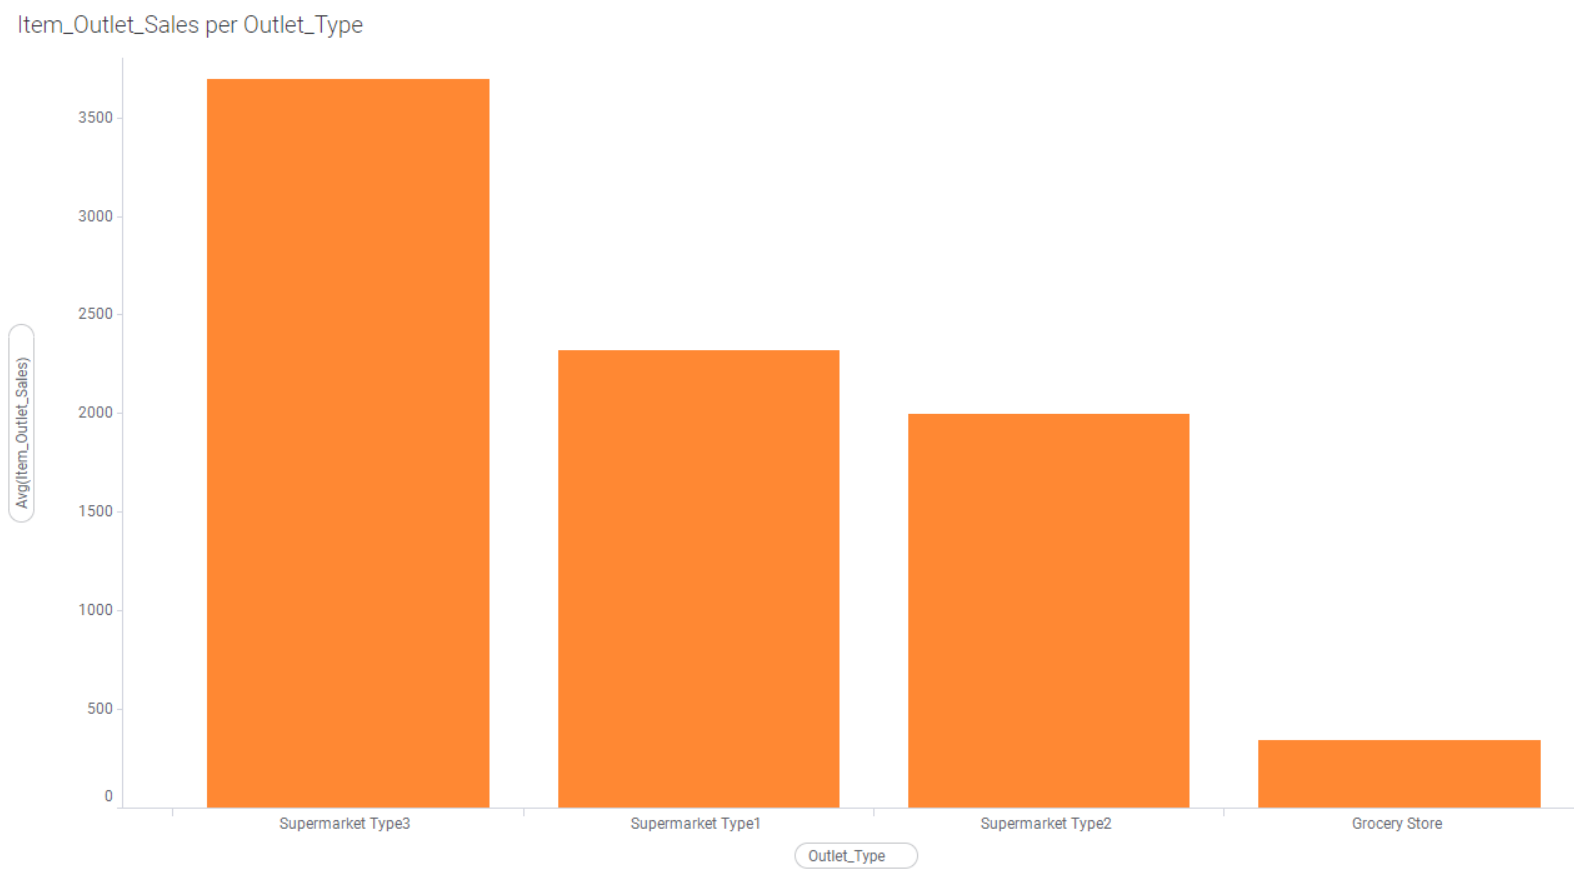
</div>

###### Numerical Data
    
As for the numerical data, I used a scatterplot to plot the data. I saw that Item Weight did not seem to have any effect on the sales as no pattern could be seen. For Item Visibility, I also created a line chart with Item Visibility as the X axis and Average Item Outlet Sales as the Y axis. Based off the line chart, it showed that items with higher visibility tend to have lower outlet sales. For Item MRP, the items with higher MRP were shown to have higher Item Outlet Sales. 

<div>
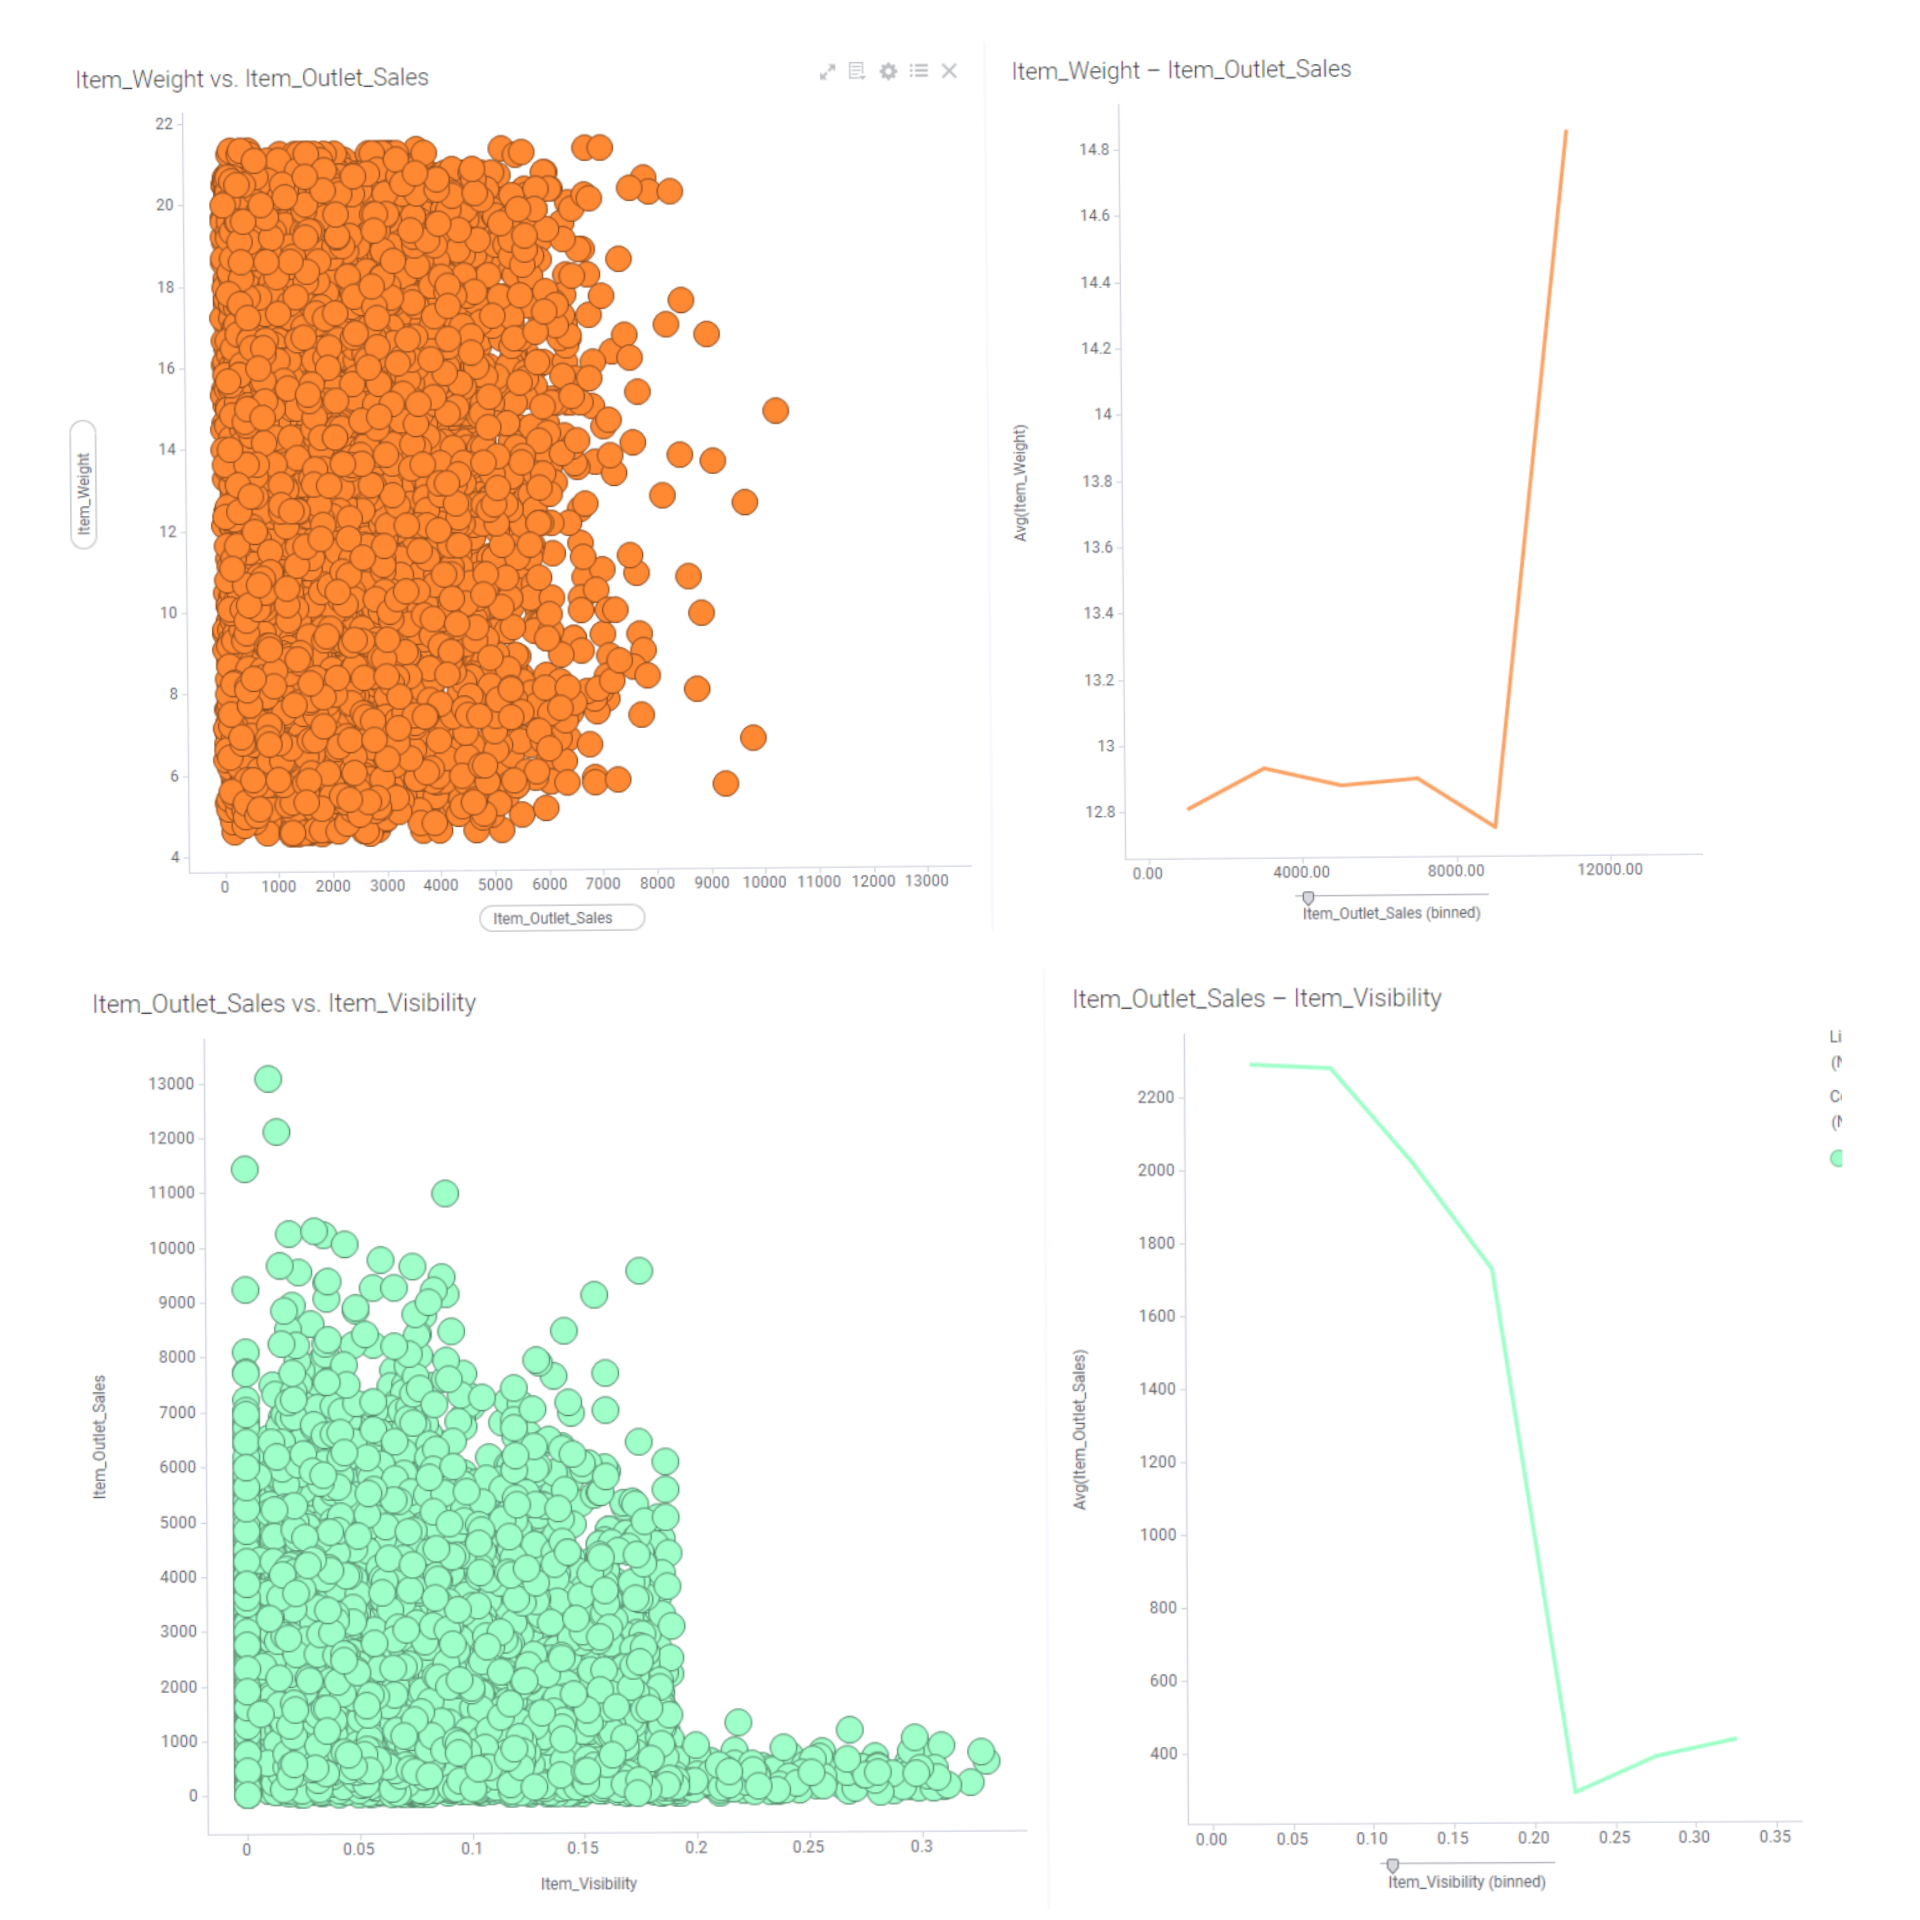
</div>

<div>
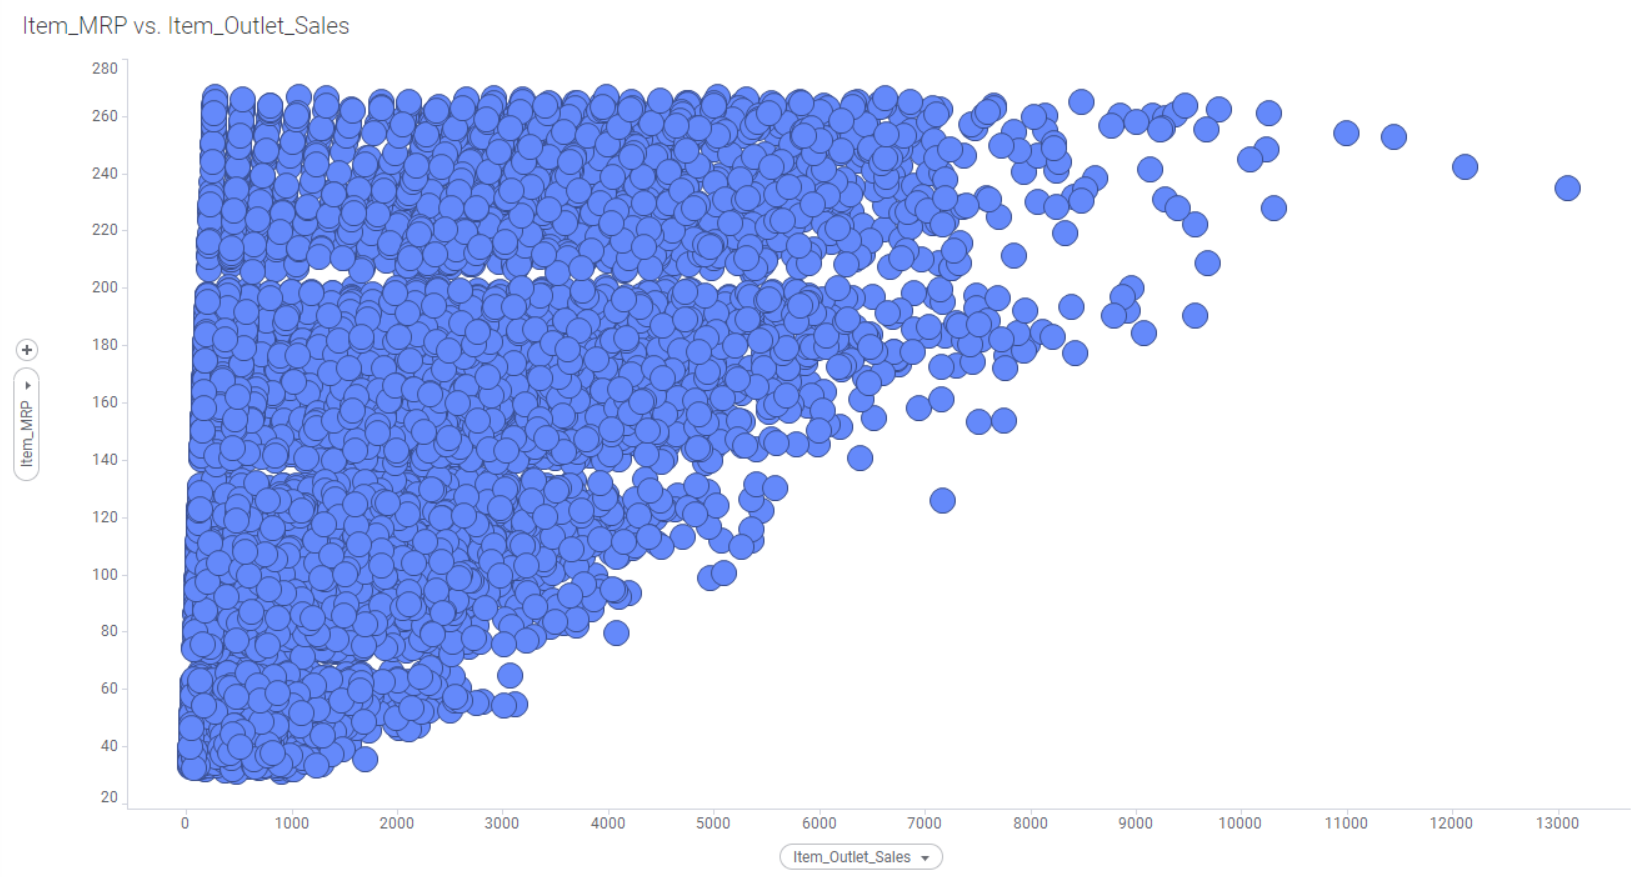
</div>

### Cleanse the Data <a id="dc">
    
For Data Cleansing, which was done after Data Exploration, we want to ensure that all the data is useful. This includes modifying any existing outliers, changing values that have the same meaning but are considered separate and getting rid of nan values.
Through a preliminary look at the data, we can see that for Item Fat Content, low fat content and regular fat content is stated in 3 and 2 different ways respectively. Low Fat was written as 'low fat', 'LF' or 'Low Fat', while Regular fat content was written as 'reg' or 'Regular'. As such, despite them having the same meaning, they would come across as different in the code and affect our model. Hence, I made us of panda's `.replace` function to replace 'low fat' and 'LF' with 'Low Fat' and 'reg' as 'Regular' to ensure that they were the only required unique values.
    
##### Missing Data <a id = "md">

For missing values, using `.isnull().sum())` would give us a count of null values for each column. We can see that there were 1021 null values for Item Weight and 1681 for Outlet Size. Since these null values aren't a small percentage of the total dataset, it isn't in our interest to do a complete case analysis and discard those records. My initial method of replacing the missing values were to use Feature Engine's pipeline imputation to impute frequent values for Outlet Size and median values for Item_Weight. 

However, after trying multiple methods, I found that using an End Tail Imputer for Item Weight provides me with a better model performance. For the End Tail Imputer, the imputation method set was iqr which uses the IQR limits to find the values to replace missing data. I set fold to be 1.5 and tail to be right. I also tried different combinations of fold to be 3 or tail to be left but it did not seem to make much of a difference. 

As for Outlet Size, I used Feature Engine's Pipeline imputation and set the missing values to be the most frequent value. Given that the most frequent value for Outlet Size was medium, the number of 'Medium' values for Outlet Size increased from under 2000 to over 3500. We can then check the X Train for null values and we can see that there are no more null values for any of the variables.

##### Outliers <a id = "out">
 
Outliers in the data may affect the performance of the machine learning models as statistical parameters are sensitive to it. The `diagnostic_plots` function provides us with a histogram, QQ plot and boxplot of the variable passed into the function. The boxplot would be able to show us if the variable had any outliers. After passing the numerical variables into the function, I could see that Item_Visibility was the only variable with multiple outliers. I tried different methods such as Trimming, Capping and ended up choosing the Winsorisation method which is a form of capping. I made use of Feature Engine's Winsorizer for Item_Visibility, setting the `capping method = 'iqr'` , `tail = 'right'` and `fold = 1`. I chose the iqr capping method as the distribution of Item_Visibility was skewed. I set the fold parameter to be 1 which makes use of the IQR value to cap the values as a higher fold would not remove all the outliers. Given that the outliers were only at the top, I set the tail to right which only caps the maximum values.
This provided me with a more symmetrical distribution, seen from the QQ plot. The boxplot also showed the removal of the outliers.
    
<div>
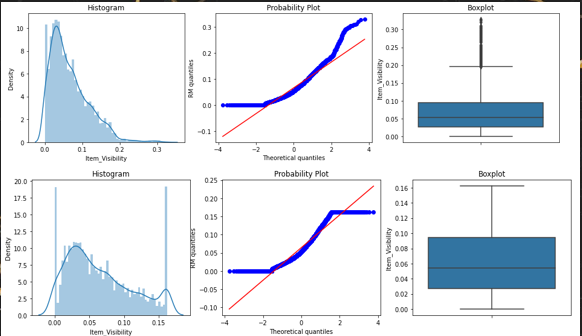
</div>

### Data Transformation <a id="dt">

##### Categorical Data <a id = "cd">
    
The categorical data provided to us are item Fat Content, Item Type, Outlet Identifier, Outlet Type, Outlet Size and Outlet Location Type. We want to convert these data into numerical representations so they can be used and calculated to allow the computer to determine more suitable algorithms for the models. We can also split these into nominal and ordinal data. Nominal data is data without any quantitative value, such as Item Type, Outlet Location Type and Outlet Type. Ordinal data refers to data that has an order, such as Item Fat Content, Outlet Size and Outlet Identifier. This can help us determine the more appropriate method to transform the categorical data as the same method for different columns may have different effect on our model performance.

The encoding method that I have chosen is One Hot Encoding with Top Categories. The reason I chose top categories is due to columns such as Outlet Identifier and Item Identifier. These columns have multiple unique variables which would overwhelm the data set and slow down the model instead. I tried different number of top categories and decided on the number 10 as it seemed to be more useful. I experimented with different methods for different variables but decided to use OHE for all the categorical variables.

##### Numerical Data <a id = "nd">

For Numerical data, some machine learning models assume that the input variables are normally distributed. Making histograms for all the numerical variables allowed me to see that Item Visibility was right-skewed, Item MRP and Item Weight were multimodal. Outlet Establishment Year did not have a normal distribution but that was acceptable as it was more of a discrete variable than a continuous one. I decided to go ahead with the Yeo-Johnson transformation for Item Visibility and was able to see that its distributions became more normal. I also chose Yeo-Johnson as it was the most versatile transformer, compared to other transformers which required non-zero or only positive values.

After the Yeo-Johnson transformation, I did Equal Width Binning with Feature Engine for Item Weight, Item Visibility and Item MRP. This allows us to convert the continuous data into categorical data, grouping it together instead of letting the computer treat it as separate values. I left out Outlet Establishment Year as it was more discrete than continuous, and the discretizer would not be effective in this case, also given the limited number of observations. Furthermore, this helps to change the distribution of variables that might be skewed or have outliers. 
    
For the discretiser, I set bins to be 40 which is the number of intervals/bins. The size of the interval would then be calculated by `( max(X) - min(X) ) / 40`. I experimented with different number of bins and other methods such as equal frequency discretization but found equal width with bins set to 40 to be the most effective. This might be due to the distributions being more normal or even. Equal frequency discretizer is more useful for skewed variables, as it divides values based off the number of observations and not the value of the observation itself. 

### Feature Engineer <a id="fe">

##### New/Drop Features <a id = "ndf">

We can look into the mathematical computation of features. This is where we can make use of existing data to derive new features which could help to train our model even further. Looking at the dataset after the previous steps, I found that the features made it hard to derive any new features from the datasets. The increased difficulty is also due to the categorical encoding method I chose, One Hot Encoding. This transformation method causes the unique values of each variable to split into multiple, making it harder to derive new features from it. As such, I did not choose to make any new features.

Furthermore, I also saw that Outlet Establishment Year was a variable with values up to 2009 which was much higher than the rest of the variables. I also realized that the variable did not have much, if any, correlation to our target variable as it was more of a discrete variable. The value was tied to the outlet, and did not have much of an effect on the item. Hence, I decided to drop the Outlet Establishment Year in X train and X test. It did not seem to make much of a difference, causing an increase of 0.0001 in the model's r-squared value.

##### Feature Scaling <a id = "fs">

For the dataset, I conducted feature scaling. This is because different variables have different ranges of values. Some variables had a range of 0 to 1 after One Hot Encoding, while others had a range up to 39.  Feature scaling changes the values of the data to follow a similar scale, ensuring that the different ranges in values do not affect the machine learning algorithms which can be sensitive to the scale and magnitude of the features as it does not have a sense of relativity or units. 

The feature scaling method I have chosen is Min Max which changes the observation value to be between 0 and 1. This allows the algorithm to have a better sense of feature importance as they’re all re-featured relative to their individual variables. I chose Min Max Scaler as it helps to keep the original distribution of the data. I also tried the other popular scaler, Standard Scaler, but it did not seem to have a positive effect on the r-squared and mse values of the model.

I did not conduct PCA for this dataset as PCA is more suited towards high dimensionality data, where the number of features outweigh the number of observations. Given that there were 5966 observations and 45 features for the train and test sets, this was considered low dimensionality data and did not need PCA. Nevertheless, I gave the method a try but found that it lowered by r-squared scores slightly.

For my code, I mainly made use of feature engine to transform the datasets. This is because sklearn handles the data in numpy arrays and requires it to be converted back to a dataframe again which is unneccessary. Feature engine is able to treat the data as is, making it a more efficient library to use.

### Linear Regression Model <a id="lrm">

The purpose of the linear regression model in this case is to predict the item outlet sales based off the properties off the item and outlet provided. These properties could then be adjusted and the potential sales could be predicted with the help of the model. We want the model to be as accurate as possible to strengthen its predictive powers. The performance and effectiveness of the model can be evaluated in multiple ways, such as Mean Absolute Error, Root Mean Squared Error and R squared. In this case, we will be looking at the RMSE and R-squared.

##### Build and Evaluate the Model <a id = "eval">

Prior to building the model, the data must be cleaned and transformed. Cleansing the data ensures that the data provided to the model is useful and there are not unnecessary values that might cause overfitting. Overfitting the model would seemingly provide better performance, but it is actually less accurate. Hence, cleaning the data is important. 
As for transformation, it is equally important as the computer might treat the data different than we do. This includes the scale and magnitude of data, as well as its units. Different features might have vastly different values, causing the computer to treat the larger value as more important. Transforming the data ensures that the algorithm is able to compare the relative relationship between data points more efficiently.

For the results of this model, we are using RMSE and R Squared. My RMSE for the train and test set is 1.24m and 1.33m respectively, while their R-squared is 0.564 and 0.563 accordingly. RMSE is Root Mean Squared Error, the standard deviation of the errors which occur during prediction. As such, a lower RMSE is better. RMSE is relative to the data provided and when using it as a metric, standardizing the data is important as it would be affected by the scale of data. Ways to reduce the RMSE include ensuring the data is less skewed, removing outliers and more. If the test set's RMSE is significantly higher than that of the train set, that might also be a sign of overfitting.

As for R Squared, R Squared is the proportion of variance in the Item Outlet Sales variable that can be explained by the independent variable (The item and outlet properties in this scenario). The closer to 1.0 for the value of R Squared, the more the item outlet sales is explained by the independent variables. A R-squared value of 0.564 means that approximately 56% of the Item Outlet Sales can be explained by the other variables. In general, adding more variables tend to increase our R-Squared values but this puts us at a risk of overfitting the data, which affects its accuracy.

For the model performance in this case, I believe that there is room for improvement. I have gone through different encoding and transformation methods to see what is best for the model, and this is an increase from my first model's performance with an RMSE of 1.6m and R-squared of 0.39.

### Summary and Further Improvements <a id="sum">

##### Summarize your findings <a id = "sf">

After data cleansing and transformation, passing the training and testing sets into the model gave me a root mean square error(RMSE) of 1.24m and 1.33m for the train and test sets respectively. Their respective r-square(RSQ) values are 0.564 and 0.563. A good RSQ value to aim for would be 0.8 while the RMSE score is relative to the scale of the data. A R-Squared value of 0.563 means that roughly 56% of the dependent variable can be explain by the independent variables, making the model performance moderate.
    
##### Explain the possible further improvements <a id = "imp">
    
Certain improvements that could be done would be to further inspect the values of the data and use different transformation methods for different variables when it is deemed to be more useful. Further advanced methods to improve model predictions would be to stack the models.